In [12]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, cross_validate #método para evaluar varios particionamientos de C-V
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from scipy import stats

# Bagging
from sklearn.ensemble import BaggingClassifier

In [2]:
data = pd.read_csv('data_set_cleaned.csv', header = 0, names=None)
data.head()

,Case1_Control0,Edad,Genero,Cycle Time,Stance Percent,Stance Time,Step Length,Step Number,Step Time,Step Cadence,...,Step Timel,Step Cadencel,Stride Numberl,Stride Lengthl,Swing Percentl,Swing Timel,Distancel,Duration Timel,Speedl,Accelerationl
0,Positivo,79,M,0.803979,0.644524,1.327075,0.796338,2,0.335486,58.280750,...,0.312041,88.428185,1,0.185463,0.459888,0.624083,1.890646,1.357033,1.393220,1.026666
1,Positivo,79,M,0.826989,0.633677,1.326004,0.823259,2,0.352115,57.346196,...,0.429035,59.169468,1,1.198056,0.423096,0.858070,1.923441,2.028073,0.948408,0.467640
2,Positivo,79,M,0.789131,0.610778,1.219237,0.739892,2,0.359121,60.114133,...,0.405821,56.550877,1,1.059078,0.382493,0.811643,1.974094,2.121983,0.930306,0.438414
3,Positivo,68,M,1.193026,0.536687,1.263887,0.741654,2,0.476885,50.955888,...,0.435792,50.936203,1,1.085094,0.369960,0.871583,1.951583,2.355888,0.828385,0.351623
4,Positivo,68,M,1.045567,0.508093,1.061983,0.817604,2,0.446011,57.412502,...,0.358499,59.642470,1,1.189026,0.356362,0.716997,1.858186,2.011989,0.923557,0.459027


In [ ]:
x = data.loc[: , ~data.columns.isin(['Case1_Control0','Genero'])].values
y = data['Case1_Control0'].values

### Fine Tuning (Mejor k)

In [4]:
# Knn sin estandarizar datos.
acc_k =[]
for k in range(1, 50):
    #KFold para un k.
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=True, random_state=1234)
    acc_test_vec=[]
    for indices_train, indices_test in kf.split(x):    
        #print("%s %s" % (x[indices_train], indices_test))
        x_train = x[indices_train]
        x_test = x[indices_test]
        knn.fit(x_train, y[indices_train])
        y_pred = knn.predict(x_test)
        acc_test_vec.append(metrics.accuracy_score(y[indices_test], y_pred))  
    acc_test_vec
    acc_k.append(np.mean(acc_test_vec))
print("Maxima exactitud=%0.5f con k=%d" % (np.max(acc_k),np.argmax(acc_k)))


Maxima exactitud=0.67690 con k=41


In [5]:
#Buscar el k que entregue la mejor exactitud para el dataset de prueba
acc_k =[]
for k in range(1, 20):
    #KFold para un k.
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=True, random_state=1234)
    acc_test_vec=[]
    for indices_train, indices_test in kf.split(x):    
        #print("%s %s" % (x[indices_train], indices_test))
        scaler = StandardScaler()
        scaler.fit(x[indices_train])
        x_train = scaler.transform(x[indices_train])
        x_test = scaler.transform(x[indices_test])
        knn.fit(x_train, y[indices_train])
        y_pred = knn.predict(x_test)
        acc_test_vec.append(metrics.accuracy_score(y[indices_test], y_pred))  
    acc_test_vec
    acc_k.append(np.mean(acc_test_vec))
print("Maxima exactitud=%0.5f con k=%d" % (np.max(acc_k),np.argmax(acc_k)))


Maxima exactitud=0.69766 con k=9


Estandarizando los datos se logra mejorar la exactitud del modelo en el diagnóstico usando un menor k, lo cual mejora la cantidad de calculo de distancias entre los datos.

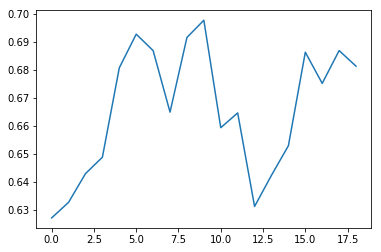

In [6]:
plt.plot(acc_k)

In [7]:
data_pca11 = pd.read_csv('data_set_pca.csv', header = 0, names=None)

In [8]:
x_pca = data_pca11.values

Maxima exactitud=0.70906 con k=22


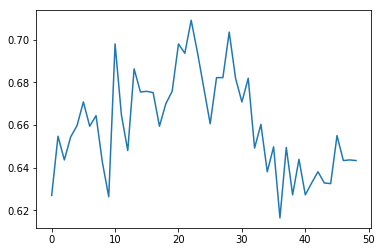

In [9]:
acc_k =[]
for k in range(1, 50):
    #KFold para un k.
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=True, random_state=1234)
    acc_test_vec=[]
    for indices_train, indices_test in kf.split(x_pca):    
        #print("%s %s" % (x[indices_train], indices_test))
        x_train = x_pca[indices_train]
        x_test = x_pca[indices_test]
        knn.fit(x_train, y[indices_train])
        y_pred = knn.predict(x_test)
        acc_test_vec.append(metrics.accuracy_score(y[indices_test], y_pred))  
    acc_test_vec
    acc_k.append(np.mean(acc_test_vec))
print("Maxima exactitud=%0.5f con k=%d" % (np.max(acc_k),np.argmax(acc_k)))

plt.plot(acc_k)


PCA no mejora la exactitud del modelo KNN.

### Bagging con KNN

Buscamos un modelo

In [44]:
param_grid = {
    'base_estimator__n_neighbors' : [stats.randint.rvs(5,20,1)],
    'n_estimators' : [stats.randint.rvs(10,120,1)],
    'max_samples' : stats.uniform(0.1,0.7),
    'max_features' : stats.uniform(0.05,0.7)
}

RS_BK = RandomizedSearchCV(BaggingClassifier(base_estimator = neighbors.KNeighborsClassifier()),
                     param_distributions=param_grid, scoring='accuracy', cv=10, n_iter=10, random_state=1234)

RS_BK.fit(x, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'base_estimator__n_neighbors': [15], 'n_estimators': [18], 'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002682CE9A860>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002682CE9A978>},
          pre_dispatch='2*n_jobs', random_state=1234, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [45]:
print('Mejores parametros:\n', RS_BK.best_params_)
print('Mejor Exactitud:\n', RS_BK.best_score_)

Mejores parametros:
 {'base_estimator__n_neighbors': 15, 'max_features': 0.5284240546204954, 'max_samples': 0.5988914188880301, 'n_estimators': 18}
Mejor Exactitud:
 0.6318681318681318


Durante el afinamiento de parametros como la busqueda de parametros es randomica, la exactitud varia con cada ejecución, sin embargo el mejor resultado fue:

**Mejores parametros:**  
 {'base_estimator__n_neighbors': 8, 'max_features': 0.4021582157154668, 'max_samples': 0.10688422479534113, 'n_estimators': 83}  
**Mejor Exactitud:**   
 0.6648351648351648